In [132]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image 
import torch.nn as nn # all neural network modules, nn.Linear, nn.Conv2d, BatchNorm, loss functions
import torch.nn.functional as F # all functions that dont have any parameters eg: activations like relu, softmax
import torch.optim as optim # all optimization algorithms, SGD, Adam, etc.
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler # gives easier dataset management and creates mini batches
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights #pretrained image classification models and weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# Step 0: Use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 1 : Define custom model
class CustomEfficientNet(nn.Module):

    def __init__(self, num_classes, weights = EfficientNet_B0_Weights.DEFAULT):
        super(CustomEfficientNet, self).__init__()
        model = efficientnet_b0(weights)
        self.feature_extractor = model.features
        self.global_average_pool = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Flatten(), # output = feature vector size : 1280,
            nn.Linear(in_features=self.feature_extractor[-1].out_channels,
                        out_features=num_classes) # in_features = 1280, out_features = 2
        )

        # freeze weights of feature extractor until the second last block
        # train the weights of the last feature map layer
        for param in self.feature_extractor[:-1].parameters():
            param.requires_grad=False
        return
    
    def forward(self, x):
        feature_maps = self.feature_extractor(x) # torch.Size([B, 1280, 7, 7])
        global_avg_pool_layer = self.global_average_pool(feature_maps) # torch.Size([B, 1280, 1, 1])
        logits = self.classifier(global_avg_pool_layer) # torch.Size([B, num_classes])

        if self.training:
            # training
            return logits
        else:
            # inference
            prob = F.softmax(logits, dim=-1) # torch.Size([B, num_classes])
            return prob


In [91]:
pretrained_weights = EfficientNet_B0_Weights.DEFAULT
model = CustomEfficientNet(num_classes=2, weights=pretrained_weights).to(device)

/Users/kavyakumar/anaconda3/envs/mlmodels/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [89]:
# Check whether custom model works on dummy data
x = torch.rand(64, 3, 512, 512)
preprocess = pretrained_weights.transforms(antialias=True) # using transforms defined by pretrained weights of efficient net
preprocess(x).shape # torch.Size([64, 3, 224, 224])
model.eval()
model(preprocess(x))


torch.Size([64, 2])


tensor([[0.4278, 0.5722],
        [0.4469, 0.5531],
        [0.4260, 0.5740],
        [0.4510, 0.5490],
        [0.4397, 0.5603],
        [0.4134, 0.5866],
        [0.4243, 0.5757],
        [0.4366, 0.5634],
        [0.4296, 0.5704],
        [0.4181, 0.5819],
        [0.4374, 0.5626],
        [0.4472, 0.5528],
        [0.4360, 0.5640],
        [0.4460, 0.5540],
        [0.4401, 0.5599],
        [0.4435, 0.5565],
        [0.4272, 0.5728],
        [0.4472, 0.5528],
        [0.4503, 0.5497],
        [0.4316, 0.5684],
        [0.4409, 0.5591],
        [0.4284, 0.5716],
        [0.4354, 0.5646],
        [0.4293, 0.5707],
        [0.4289, 0.5711],
        [0.4366, 0.5634],
        [0.4260, 0.5740],
        [0.4135, 0.5865],
        [0.4292, 0.5708],
        [0.4412, 0.5588],
        [0.4400, 0.5600],
        [0.4242, 0.5758],
        [0.4383, 0.5617],
        [0.4172, 0.5828],
        [0.4338, 0.5662],
        [0.4319, 0.5681],
        [0.4303, 0.5697],
        [0.4244, 0.5756],
        [0.4

In [109]:
# Define loss, optimizer, and training pipeline hyperparameters
class_weightage = torch.FloatTensor([1., 5.]).to(device) # hyperparam
lr = 1e-4
criterion = nn.CrossEntropyLoss(weight=class_weightage) # multiplying anomaly class weights times 5
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 30
batch_size = 8
target_acc = 0.98 # early stopping strategy
root = "data"
sub_category = "screw"
root = os.path.join(root, sub_category)


In [126]:
# Define Dataset and Dataloader
class MVTEC_Dataset(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.classes = ["Good", "Anomaly"]
        self.transform = transform
        
        self.image_filenames, self.image_labels = self._get_images_and_labels()
        return
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        label = self.image_labels[idx]
        img = Image.open(filename).convert('RGB') # convert 1 channel to 3 channel image
        img_tensor = self.transform(img)
        label_tensor = torch.as_tensor(label, dtype=torch.long)
        del img
        return img_tensor, label_tensor

    def _get_images_and_labels(self):
        datasets = ["train", "test"]
        filenames, labels = [], []

        for folder in datasets:
            folder = os.path.join(self.root, folder)
            for class_folder in os.listdir(folder):
                label = 0 if class_folder=="good" else 1
                class_folder = os.path.join(folder, class_folder)
                class_images = os.listdir(class_folder)
                class_images = [os.path.join(class_folder, image) 
                                for image in class_images if image.find(".png")> -1]
                
                filenames.extend(class_images)
                labels.extend([label] * len(class_images)) # as all labels of 1 category are stored together
                del class_folder, class_images

        print("Dataset : {}, \n Images : {}, \n Anomalies found : {:.3f}"
              .format(self.root, len(filenames), np.sum(labels)/len(labels)))
        return filenames, labels

In [127]:
pretrained_transform = pretrained_weights.transforms(antialias=True)
dataset = MVTEC_Dataset(root=root, transform=pretrained_transform)
train_idx, test_idx = train_test_split(
    np.arange(dataset.__len__()),
    test_size=0.2,
    random_state=42,
    shuffle=True) # (384, 96)

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(
    dataset=dataset, 
    batch_size=batch_size,
    sampler=train_sampler
)
test_loader = DataLoader(
    dataset=dataset, 
    batch_size=batch_size,
    sampler=test_sampler
)
print(len(train_loader), len(test_loader))

Dataset : data/screw, 
 Images : 480, 
 Anomalies found : 0.248
48 12


In [129]:
# Training Pipeline
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    n_samples = 0

    for data, target in train_loader:
        
        # move data to gpu if available
        data, target = data.to(device), target.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        pred_logits = model(data) # (B, num_classes)

        # calculate loss
        batch_loss = criterion(pred_logits, target)

        # backward propagation
        batch_loss.backward()

        # update weights to minimize loss
        optimizer.step()

        # update metrics
        running_loss += batch_loss.item() * len(data) # loss will be one scalar for an entire batch, so multiply with batch size
        pred_class = torch.argmax(pred_logits, dim= -1)
        running_corrects += torch.sum(pred_class == target)
        n_samples += len(data)
    
    epoch_loss = running_loss / n_samples
    epoch_acc = running_corrects / n_samples
    print("Epoch : {}, Loss : {:.3f}, Accuracy : {:.3f}".format(
        epoch, epoch_loss, epoch_acc
    ))

    # incorporate early stopping if a target accuracy is met
    if target_acc != None:
        if epoch_acc > target_acc:
            print("Early stopping at epoch : {} with accuracy : {}".format(
                epoch, epoch_acc
            ))
            break

Epoch : 0, Loss : 0.664, Accuracy : 0.669
Epoch : 1, Loss : 0.605, Accuracy : 0.654
Epoch : 2, Loss : 0.572, Accuracy : 0.646
Epoch : 3, Loss : 0.533, Accuracy : 0.669
Epoch : 4, Loss : 0.513, Accuracy : 0.740
Epoch : 5, Loss : 0.473, Accuracy : 0.755
Epoch : 6, Loss : 0.480, Accuracy : 0.737
Epoch : 7, Loss : 0.464, Accuracy : 0.773
Epoch : 8, Loss : 0.444, Accuracy : 0.799
Epoch : 9, Loss : 0.416, Accuracy : 0.799
Epoch : 10, Loss : 0.393, Accuracy : 0.818
Epoch : 11, Loss : 0.396, Accuracy : 0.826
Epoch : 12, Loss : 0.334, Accuracy : 0.872
Epoch : 13, Loss : 0.361, Accuracy : 0.852
Epoch : 14, Loss : 0.334, Accuracy : 0.852
Epoch : 15, Loss : 0.326, Accuracy : 0.862
Epoch : 16, Loss : 0.306, Accuracy : 0.867
Epoch : 17, Loss : 0.280, Accuracy : 0.906
Epoch : 18, Loss : 0.259, Accuracy : 0.875
Epoch : 19, Loss : 0.286, Accuracy : 0.891
Epoch : 20, Loss : 0.306, Accuracy : 0.883
Epoch : 21, Loss : 0.270, Accuracy : 0.885
Epoch : 22, Loss : 0.259, Accuracy : 0.898
Epoch : 23, Loss : 0.

torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8, 2])
running corrects : 0.8646
Accuracy: 0.8646
Balanced Accuracy: 0.8307



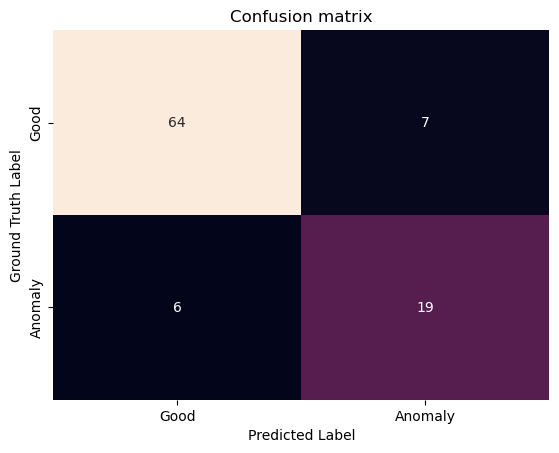

In [135]:
# Evaluate performance on test set
model.eval()
n_samples = 0
y_true, y_pred = np.empty(shape=(0,)), np.empty(shape=(0,))
for data, targets in test_loader:
    data, targets = data.to(device), targets.to(device)

    pred_softmax = model(data)
    pred_class = torch.argmax(pred_softmax, dim = -1)

    targets = targets.to("cpu").numpy()
    pred_class = pred_class.to("cpu").numpy()

    y_true = np.concatenate((y_true, targets))
    y_pred = np.concatenate((y_pred, pred_class))
    n_samples += len(data)

running_corrects = np.sum(y_pred == y_true)
accuracy = accuracy_score(y_pred=y_pred, y_true=y_true)
balanced_accuracy = balanced_accuracy_score(y_pred=y_pred, y_true=y_true)

print("running corrects : {:.4f}".format(running_corrects/n_samples))
print("Accuracy: {:.4f}".format(accuracy))
print("Balanced Accuracy: {:.4f}".format(balanced_accuracy))
print()

confusion = confusion_matrix(y_pred=y_pred, y_true=y_true)
# plt.figure(figsize=[5,5])
sns.heatmap(
    confusion,
    annot=True,
    cbar=False,
    xticklabels=dataset.classes,
    yticklabels=dataset.classes
)
plt.xlabel("Predicted Label")
plt.ylabel("Ground Truth Label")
plt.title("Confusion matrix")
plt.show()